# Test quality of matches

Import files

In [1]:
from ms2query.ms2library import MS2Library


validation_spectra_file = "../downloads/gnps_210409/spectra/ALL_GNPS_210409_val_split.pickle"
tanimoto_scores_df_file = "../downloads/gnps_210409/ALL_GNPS_210409_positive_tanimoto_scores.pickle"


sqlite_file =  "../downloads/gnps_210409/spectra/ALL_GNPS_210409_train_split.sqlite"

# Models
s2v_model_file = "../downloads/gnps_210409/models/ALL_GNPS_210409_Spec2Vec_ms2query.model"
ms2ds_model_file = "../downloads/gnps_210409/models/ms2ds_20210420-141937_data210409_10k_500_500_200.hdf5"

# Embeddings
s2v_embeddings_file =  "../downloads/gnps_210409/embeddings/s2v_embeddings_train_spectra_210426.pickle"
ms2ds_embeddings_file =  "../downloads/gnps_210409/embeddings/ms2ds_embeddings_train_spectra_210426.pickle"


### Split validation spectra into spectra with library matches and spectra without library matches
The validation spectra contain 2299 spectra (of 250 inchikeys) that do not have any match in the library and 2000 spectra that have at least one match in the library. 

In [2]:
from ms2query.utils import load_pickled_file

validation_spectra = load_pickled_file(validation_spectra_file)
validation_spectra_without_match = validation_spectra[:2299]
# validation_spectra_with_match = validation_spectra[2299:]

Get matches for validation spectra without match

In [5]:
ms2query_model = "../downloads/gnps_210409/train_ms2query_model/ms2query_model_all_scores.hdf5"
ms2library = MS2Library(sqlite_file, s2v_model_file, ms2ds_model_file, s2v_embeddings_file, ms2ds_embeddings_file)
print("Calculating all MS2DS scores")

result = ms2library.select_best_matches(validation_spectra_without_match, ms2query_model, preselection_cut_off = 2000)
import pickle
pickle.dump(result, open("../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores.pickle", "wb"))

Calculating all MS2DS scores


collecting matches info:   0%|▎                                                                                                                                | 5/2299 [00:14<1:27:55,  2.30s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.01%.


collecting matches info:   1%|▋                                                                                                                               | 13/2299 [00:28<1:10:05,  1.84s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.


collecting matches info:   3%|███▊                                                                                                                            | 68/2299 [02:08<1:08:02,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.


collecting matches info:   3%|███▉                                                                                                                            | 70/2299 [02:12<1:07:30,  1.82s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.


collecting matches info:   3%|████▎                                                                                                                           | 77/2299 [02:25<1:07:29,  1.82s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.


collecting matches info:   3%|████▎                                                                                                                           | 78/2299 [02:27<1:07:19,  1.82s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.


collecting matches info:   4%|█████▏                                                                                                                          | 93/2299 [02:53<1:06:06,  1.80s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.


collecting matches info:   4%|█████▋                                                                                                                         | 102/2299 [03:10<1:06:47,  1.82s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.


collecting matches info:   4%|█████▋                                                                                                                         | 103/2299 [03:12<1:06:30,  1.82s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.


collecting matches info:   5%|█████▊                                                                                                                         | 105/2299 [03:15<1:05:48,  1.80s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.


collecting matches info:   6%|███████▍                                                                                                                       | 135/2299 [04:09<1:04:32,  1.79s/it]

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.47%.


collecting matches info:   6%|████████                                                                                                                       | 146/2299 [04:29<1:03:55,  1.78s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.


collecting matches info:   6%|████████                                                                                                                       | 147/2299 [04:30<1:04:18,  1.79s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.


collecting matches info:   7%|█████████▏                                                                                                                     | 167/2299 [05:07<1:04:07,  1.80s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.


collecting matches info:   7%|█████████▎                                                                                                                     | 168/2299 [05:08<1:04:10,  1.81s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.


collecting matches info:   7%|█████████▍                                                                                                                     | 171/2299 [05:14<1:03:51,  1.80s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.47%.


collecting matches info:   9%|███████████▍                                                                                                                   | 207/2299 [06:19<1:03:59,  1.84s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.


collecting matches info:   9%|███████████▊                                                                                                                   | 213/2299 [06:31<1:07:02,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.


collecting matches info:   9%|███████████▉                                                                                                                   | 217/2299 [06:38<1:03:22,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.


collecting matches info:  10%|████████████▋                                                                                                                  | 229/2299 [06:59<1:01:44,  1.79s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.92%.


collecting matches info:  12%|███████████████▋                                                                                                               | 284/2299 [22:27<2:13:17,  3.97s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.


collecting matches info:  12%|███████████████▋                                                                                                               | 285/2299 [22:29<1:51:12,  3.31s/it]

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.36%.


collecting matches info:  12%|███████████████▊                                                                                                               | 287/2299 [22:33<1:24:52,  2.53s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.67%.


collecting matches info:  13%|███████████████▉                                                                                                               | 288/2299 [22:34<1:17:13,  2.30s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.80%.


collecting matches info:  13%|███████████████▉                                                                                                               | 289/2299 [22:36<1:12:01,  2.15s/it]

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.16%.


collecting matches info:  13%|████████████████▎                                                                                                              | 295/2299 [22:47<1:01:21,  1.84s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.06%.


collecting matches info:  13%|████████████████▍                                                                                                              | 297/2299 [22:51<1:00:16,  1.81s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.35%.


collecting matches info:  13%|████████████████▊                                                                                                              | 305/2299 [23:09<1:19:11,  2.38s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.55%.


collecting matches info:  14%|█████████████████▌                                                                                                             | 317/2299 [23:35<1:04:34,  1.95s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.


collecting matches info:  14%|█████████████████▌                                                                                                             | 318/2299 [23:37<1:02:34,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.


collecting matches info:  14%|█████████████████▌                                                                                                             | 319/2299 [23:38<1:01:34,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.


collecting matches info:  15%|███████████████████▌                                                                                                             | 349/2299 [24:34<58:56,  1.81s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.63%.


collecting matches info:  15%|███████████████████▋                                                                                                             | 350/2299 [24:35<59:10,  1.82s/it]

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.22%.


collecting matches info:  15%|███████████████████▍                                                                                                           | 352/2299 [24:39<1:00:40,  1.87s/it]

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.11%.


collecting matches info:  15%|███████████████████▌                                                                                                           | 353/2299 [24:41<1:00:23,  1.86s/it]

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.04%.


collecting matches info:  16%|███████████████████▋                                                                                                           | 357/2299 [24:49<1:00:01,  1.85s/it]

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.


collecting matches info:  16%|████████████████████                                                                                                             | 358/2299 [24:50<59:46,  1.85s/it]

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.06%.


collecting matches info:  16%|████████████████████▎                                                                                                            | 362/2299 [24:58<59:04,  1.83s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.80%.


collecting matches info:  16%|████████████████████▎                                                                                                            | 363/2299 [25:00<59:27,  1.84s/it]

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.28%.


collecting matches info:  16%|████████████████████▌                                                                                                            | 366/2299 [25:05<59:24,  1.84s/it]

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.


collecting matches info:  16%|████████████████████▌                                                                                                            | 367/2299 [25:07<59:07,  1.84s/it]

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.08%.


collecting matches info:  16%|████████████████████▋                                                                                                            | 368/2299 [25:09<59:07,  1.84s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  16%|████████████████████▋                                                                                                            | 369/2299 [25:11<58:52,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.


collecting matches info:  16%|████████████████████▊                                                                                                            | 370/2299 [25:12<58:46,  1.83s/it]

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.68%.


collecting matches info:  16%|████████████████████▊                                                                                                            | 371/2299 [25:14<58:53,  1.83s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.24%.


collecting matches info:  16%|████████████████████▊                                                                                                            | 372/2299 [25:16<58:43,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.


collecting matches info:  16%|████████████████████▉                                                                                                            | 373/2299 [25:18<58:44,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.


collecting matches info:  17%|█████████████████████▋                                                                                                           | 386/2299 [25:42<59:48,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.08%.


collecting matches info:  17%|█████████████████████▍                                                                                                         | 389/2299 [25:50<1:18:23,  2.46s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.


collecting matches info:  18%|██████████████████████▋                                                                                                          | 404/2299 [26:19<59:03,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.


collecting matches info:  18%|██████████████████████▊                                                                                                        | 414/2299 [26:45<1:58:29,  3.77s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.


collecting matches info:  18%|██████████████████████▉                                                                                                        | 416/2299 [26:55<2:22:47,  4.55s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.


collecting matches info:  18%|███████████████████████▍                                                                                                       | 424/2299 [27:38<2:45:02,  5.28s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.


collecting matches info:  19%|███████████████████████▌                                                                                                       | 426/2299 [27:49<2:44:46,  5.28s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.57%.


collecting matches info:  19%|███████████████████████▋                                                                                                       | 428/2299 [27:59<2:45:56,  5.32s/it]

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.


collecting matches info:  19%|███████████████████████▊                                                                                                       | 430/2299 [28:10<2:45:22,  5.31s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.


collecting matches info:  20%|██████████████████████████▏                                                                                                      | 466/2299 [30:06<57:33,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.


collecting matches info:  20%|██████████████████████████▏                                                                                                      | 467/2299 [30:08<56:56,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.


collecting matches info:  21%|██████████████████████████▌                                                                                                      | 473/2299 [30:19<55:54,  1.84s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.


collecting matches info:  21%|██████████████████████████▌                                                                                                      | 474/2299 [30:21<56:16,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.


collecting matches info:  21%|███████████████████████████                                                                                                      | 482/2299 [30:36<56:27,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.63%.


collecting matches info:  21%|███████████████████████████▏                                                                                                     | 484/2299 [30:39<57:12,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.17%.


collecting matches info:  21%|███████████████████████████▎                                                                                                     | 486/2299 [30:43<57:14,  1.89s/it]

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.58%.


collecting matches info:  21%|███████████████████████████▎                                                                                                     | 487/2299 [30:45<57:29,  1.90s/it]

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.


collecting matches info:  21%|███████████████████████████▍                                                                                                     | 488/2299 [30:47<57:58,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.


collecting matches info:  21%|███████████████████████████▍                                                                                                     | 489/2299 [30:49<58:25,  1.94s/it]

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.23%.


collecting matches info:  21%|███████████████████████████▍                                                                                                     | 490/2299 [30:51<57:56,  1.92s/it]

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.


collecting matches info:  21%|███████████████████████████▌                                                                                                     | 491/2299 [30:53<57:54,  1.92s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.


collecting matches info:  21%|███████████████████████████▌                                                                                                     | 492/2299 [30:55<58:26,  1.94s/it]

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.07%.


collecting matches info:  21%|███████████████████████████▋                                                                                                     | 493/2299 [30:57<57:56,  1.93s/it]

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.


collecting matches info:  21%|███████████████████████████▋                                                                                                     | 494/2299 [30:59<57:59,  1.93s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.


collecting matches info:  22%|███████████████████████████▉                                                                                                     | 499/2299 [31:08<57:00,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.


collecting matches info:  22%|████████████████████████████▎                                                                                                    | 505/2299 [31:20<56:24,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.


collecting matches info:  22%|████████████████████████████▋                                                                                                    | 512/2299 [31:33<56:36,  1.90s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.


collecting matches info:  22%|████████████████████████████▊                                                                                                    | 513/2299 [31:35<57:06,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.


collecting matches info:  22%|█████████████████████████████                                                                                                    | 517/2299 [31:43<57:08,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.


collecting matches info:  25%|███████████████████████████████▋                                                                                                 | 565/2299 [33:14<54:12,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.


collecting matches info:  25%|███████████████████████████████▊                                                                                                 | 566/2299 [33:16<54:46,  1.90s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.


collecting matches info:  25%|███████████████████████████████▊                                                                                                 | 567/2299 [33:17<54:44,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.


collecting matches info:  25%|████████████████████████████████                                                                                                 | 571/2299 [33:25<55:37,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.


collecting matches info:  25%|████████████████████████████████▎                                                                                                | 576/2299 [33:35<54:08,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.


collecting matches info:  25%|████████████████████████████████▉                                                                                                | 586/2299 [33:53<53:36,  1.88s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.


collecting matches info:  26%|█████████████████████████████████▌                                                                                               | 598/2299 [34:15<51:54,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.


collecting matches info:  26%|█████████████████████████████████▌                                                                                               | 599/2299 [34:17<51:46,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.


collecting matches info:  26%|██████████████████████████████████                                                                                               | 608/2299 [34:34<52:20,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.


collecting matches info:  27%|██████████████████████████████████▌                                                                                              | 617/2299 [34:51<51:33,  1.84s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.85%.


collecting matches info:  27%|██████████████████████████████████▊                                                                                              | 620/2299 [34:56<51:54,  1.85s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.


collecting matches info:  27%|██████████████████████████████████▉                                                                                              | 623/2299 [35:02<52:21,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.


collecting matches info:  27%|███████████████████████████████████▎                                                                                             | 630/2299 [35:15<53:05,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.


collecting matches info:  27%|███████████████████████████████████▍                                                                                             | 632/2299 [35:19<52:37,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.


collecting matches info:  28%|████████████████████████████████████▏                                                                                            | 644/2299 [35:42<52:41,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.


collecting matches info:  28%|████████████████████████████████████▏                                                                                            | 646/2299 [35:46<53:05,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.


collecting matches info:  29%|████████████████████████████████████▉                                                                                            | 658/2299 [36:08<51:11,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.


collecting matches info:  29%|█████████████████████████████████████                                                                                            | 660/2299 [36:12<50:41,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.


collecting matches info:  29%|█████████████████████████████████████▏                                                                                           | 663/2299 [36:18<51:17,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.


collecting matches info:  29%|█████████████████████████████████████▍                                                                                           | 668/2299 [36:27<50:55,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.35%.


collecting matches info:  29%|█████████████████████████████████████▊                                                                                           | 673/2299 [36:36<49:48,  1.84s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  29%|█████████████████████████████████████▉                                                                                           | 677/2299 [36:44<51:49,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.


collecting matches info:  30%|██████████████████████████████████████▎                                                                                          | 682/2299 [36:53<50:09,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.


collecting matches info:  30%|██████████████████████████████████████▍                                                                                          | 684/2299 [36:57<51:32,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  30%|██████████████████████████████████████▌                                                                                          | 687/2299 [37:03<51:07,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.


collecting matches info:  30%|██████████████████████████████████████▊                                                                                          | 692/2299 [37:12<50:32,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.


collecting matches info:  30%|███████████████████████████████████████                                                                                          | 696/2299 [37:20<50:10,  1.88s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.09%.


collecting matches info:  31%|███████████████████████████████████████▍                                                                                         | 702/2299 [37:31<50:28,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.67%.


collecting matches info:  31%|███████████████████████████████████████▌                                                                                         | 706/2299 [37:39<50:03,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.76%.


collecting matches info:  31%|███████████████████████████████████████▊                                                                                         | 709/2299 [37:44<50:17,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.


collecting matches info:  31%|████████████████████████████████████████▎                                                                                        | 719/2299 [38:03<49:39,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.


collecting matches info:  33%|██████████████████████████████████████████▉                                                                                      | 766/2299 [39:32<47:42,  1.87s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.


collecting matches info:  33%|███████████████████████████████████████████                                                                                      | 768/2299 [39:36<47:36,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.78%.


collecting matches info:  34%|███████████████████████████████████████████▎                                                                                     | 772/2299 [39:44<49:31,  1.95s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.


collecting matches info:  34%|███████████████████████████████████████████▌                                                                                     | 776/2299 [39:51<48:30,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.


collecting matches info:  34%|███████████████████████████████████████████▋                                                                                     | 779/2299 [39:57<47:31,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.49%.


collecting matches info:  34%|███████████████████████████████████████████▉                                                                                     | 783/2299 [40:04<46:53,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.15%.


collecting matches info:  34%|███████████████████████████████████████████▉                                                                                     | 784/2299 [40:06<46:53,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.96%.


collecting matches info:  34%|████████████████████████████████████████████                                                                                     | 785/2299 [40:08<46:58,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.55%.


collecting matches info:  34%|████████████████████████████████████████████                                                                                     | 786/2299 [40:10<47:09,  1.87s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.69%.


collecting matches info:  34%|████████████████████████████████████████████▍                                                                                    | 791/2299 [40:19<47:09,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.


collecting matches info:  35%|████████████████████████████████████████████▋                                                                                    | 797/2299 [40:31<47:18,  1.89s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.33%.


collecting matches info:  35%|█████████████████████████████████████████████▎                                                                                   | 807/2299 [40:49<47:17,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.55%.


collecting matches info:  35%|█████████████████████████████████████████████▋                                                                                   | 814/2299 [41:04<52:55,  2.14s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.14%.


collecting matches info:  35%|█████████████████████████████████████████████▋                                                                                   | 815/2299 [41:06<50:32,  2.04s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.45%.


collecting matches info:  35%|█████████████████████████████████████████████▊                                                                                   | 816/2299 [41:08<48:42,  1.97s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.52%.


collecting matches info:  36%|█████████████████████████████████████████████▉                                                                                   | 819/2299 [41:14<46:30,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.23%.


collecting matches info:  36%|██████████████████████████████████████████████                                                                                   | 821/2299 [41:17<45:34,  1.85s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.


collecting matches info:  36%|██████████████████████████████████████████████▎                                                                                  | 825/2299 [41:24<44:47,  1.82s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.69%.


collecting matches info:  36%|██████████████████████████████████████████████▎                                                                                  | 826/2299 [41:26<45:10,  1.84s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.90%.


collecting matches info:  36%|██████████████████████████████████████████████▌                                                                                  | 829/2299 [41:32<45:59,  1.88s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.64%.


collecting matches info:  36%|██████████████████████████████████████████████▋                                                                                  | 831/2299 [41:36<45:27,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.


collecting matches info:  36%|██████████████████████████████████████████████▋                                                                                  | 832/2299 [41:38<45:09,  1.85s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.38%.


collecting matches info:  36%|███████████████████████████████████████████████                                                                                  | 838/2299 [41:48<44:29,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.70%.


collecting matches info:  37%|███████████████████████████████████████████████▏                                                                                 | 840/2299 [41:52<45:03,  1.85s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.


collecting matches info:  37%|███████████████████████████████████████████████▎                                                                                 | 843/2299 [41:58<44:30,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.70%.


collecting matches info:  37%|███████████████████████████████████████████████▎                                                                                 | 844/2299 [42:00<44:59,  1.86s/it]

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.


collecting matches info:  37%|███████████████████████████████████████████████▍                                                                                 | 846/2299 [42:03<44:41,  1.85s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.


collecting matches info:  37%|███████████████████████████████████████████████▋                                                                                 | 849/2299 [42:09<44:39,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.


collecting matches info:  37%|███████████████████████████████████████████████▊                                                                                 | 853/2299 [42:17<47:51,  1.99s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.34%.


collecting matches info:  38%|████████████████████████████████████████████████▍                                                                                | 863/2299 [42:37<46:20,  1.94s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.


collecting matches info:  39%|█████████████████████████████████████████████████▊                                                                               | 888/2299 [43:27<46:47,  1.99s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.


collecting matches info:  39%|█████████████████████████████████████████████████▉                                                                               | 889/2299 [43:29<46:19,  1.97s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.


collecting matches info:  39%|█████████████████████████████████████████████████▉                                                                               | 890/2299 [43:31<45:35,  1.94s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.


collecting matches info:  39%|██████████████████████████████████████████████████▊                                                                              | 905/2299 [43:59<43:05,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.


collecting matches info:  39%|██████████████████████████████████████████████████▉                                                                              | 907/2299 [44:03<43:20,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.


collecting matches info:  40%|███████████████████████████████████████████████████                                                                              | 910/2299 [44:09<43:36,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.


collecting matches info:  40%|███████████████████████████████████████████████████▏                                                                             | 912/2299 [44:13<43:09,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.64%.


collecting matches info:  40%|███████████████████████████████████████████████████▍                                                                             | 917/2299 [44:22<44:27,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.45%.


collecting matches info:  40%|███████████████████████████████████████████████████▌                                                                             | 918/2299 [44:24<44:15,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.55%.


collecting matches info:  40%|███████████████████████████████████████████████████▌                                                                             | 920/2299 [44:28<44:23,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.67%.


collecting matches info:  40%|████████████████████████████████████████████████████                                                                             | 927/2299 [44:42<44:51,  1.96s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.


collecting matches info:  41%|████████████████████████████████████████████████████▋                                                                            | 938/2299 [45:06<45:03,  1.99s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.


collecting matches info:  41%|█████████████████████████████████████████████████████▎                                                                           | 951/2299 [45:31<41:59,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.


collecting matches info:  41%|█████████████████████████████████████████████████████▍                                                                           | 952/2299 [45:33<41:44,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.


collecting matches info:  41%|█████████████████████████████████████████████████████▍                                                                           | 953/2299 [45:35<41:33,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.


collecting matches info:  41%|█████████████████████████████████████████████████████▌                                                                           | 954/2299 [45:37<41:25,  1.85s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.15%.


collecting matches info:  42%|█████████████████████████████████████████████████████▉                                                                           | 962/2299 [45:52<42:17,  1.90s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.


collecting matches info:  42%|██████████████████████████████████████████████████████▌                                                                          | 973/2299 [46:13<42:01,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.


collecting matches info:  43%|███████████████████████████████████████████████████████                                                                          | 982/2299 [46:30<42:24,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.


collecting matches info:  43%|████████████████████████████████████████████████████████                                                                         | 999/2299 [47:03<43:18,  2.00s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  44%|███████████████████████████████████████████████████████▋                                                                        | 1001/2299 [47:07<42:49,  1.98s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.85%.


collecting matches info:  44%|████████████████████████████████████████████████████████▏                                                                       | 1010/2299 [47:24<41:40,  1.94s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.56%.


collecting matches info:  44%|████████████████████████████████████████████████████████▎                                                                       | 1011/2299 [47:26<42:05,  1.96s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.85%.


collecting matches info:  44%|████████████████████████████████████████████████████████▎                                                                       | 1012/2299 [47:28<42:40,  1.99s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.


collecting matches info:  44%|████████████████████████████████████████████████████████▊                                                                       | 1021/2299 [47:45<40:55,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.


collecting matches info:  45%|█████████████████████████████████████████████████████████▎                                                                      | 1029/2299 [48:01<40:08,  1.90s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.


collecting matches info:  45%|█████████████████████████████████████████████████████████▍                                                                      | 1031/2299 [48:04<40:39,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.


collecting matches info:  45%|█████████████████████████████████████████████████████████▌                                                                      | 1034/2299 [48:10<39:44,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.


collecting matches info:  45%|█████████████████████████████████████████████████████████▋                                                                      | 1036/2299 [48:14<39:43,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.


collecting matches info:  45%|█████████████████████████████████████████████████████████▊                                                                      | 1039/2299 [48:19<39:16,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.


collecting matches info:  45%|█████████████████████████████████████████████████████████▉                                                                      | 1040/2299 [48:22<42:50,  2.04s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.


collecting matches info:  45%|██████████████████████████████████████████████████████████                                                                      | 1043/2299 [48:28<42:06,  2.01s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.


collecting matches info:  45%|██████████████████████████████████████████████████████████▏                                                                     | 1045/2299 [48:32<40:43,  1.95s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.37%.


collecting matches info:  46%|██████████████████████████████████████████████████████████▎                                                                     | 1047/2299 [48:35<39:38,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.


collecting matches info:  46%|██████████████████████████████████████████████████████████▎                                                                     | 1048/2299 [48:37<39:37,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.


collecting matches info:  46%|██████████████████████████████████████████████████████████▋                                                                     | 1054/2299 [48:48<38:20,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.


collecting matches info:  46%|██████████████████████████████████████████████████████████▋                                                                     | 1055/2299 [48:50<38:22,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.


collecting matches info:  46%|██████████████████████████████████████████████████████████▊                                                                     | 1056/2299 [48:52<38:34,  1.86s/it]

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.


collecting matches info:  46%|███████████████████████████████████████████████████████████▎                                                                    | 1066/2299 [49:11<38:04,  1.85s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.


collecting matches info:  47%|████████████████████████████████████████████████████████████                                                                    | 1078/2299 [49:33<37:47,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.


collecting matches info:  47%|████████████████████████████████████████████████████████████▍                                                                   | 1086/2299 [49:48<38:13,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.


collecting matches info:  47%|████████████████████████████████████████████████████████████▋                                                                   | 1090/2299 [49:56<37:55,  1.88s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.55%.


collecting matches info:  47%|████████████████████████████████████████████████████████████▊                                                                   | 1092/2299 [50:00<38:36,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.


collecting matches info:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 1103/2299 [50:20<36:55,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.


collecting matches info:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 1104/2299 [50:22<37:30,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.


collecting matches info:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 1109/2299 [50:32<38:00,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.


collecting matches info:  48%|██████████████████████████████████████████████████████████████                                                                  | 1114/2299 [50:41<36:50,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.


collecting matches info:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 1120/2299 [50:53<37:48,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.


collecting matches info:  56%|████████████████████████████████████████████████████████████████████████▏                                                       | 1296/2299 [56:32<32:34,  1.95s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.08%.


collecting matches info:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 1305/2299 [56:55<39:53,  2.41s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.


collecting matches info:  57%|████████████████████████████████████████████████████████████████████████▊                                                       | 1308/2299 [57:02<37:16,  2.26s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.92%.


collecting matches info:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 1312/2299 [57:13<46:50,  2.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.33%.


collecting matches info:  57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 1320/2299 [57:31<35:48,  2.19s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.17%.


collecting matches info:  58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 1326/2299 [57:46<37:03,  2.29s/it]

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.


collecting matches info:  58%|██████████████████████████████████████████████████████████████████████████                                                      | 1331/2299 [57:56<34:40,  2.15s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.


collecting matches info:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 1368/2299 [59:08<29:20,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.


collecting matches info:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 1374/2299 [59:19<28:54,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.


collecting matches info:  60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 1381/2299 [59:32<28:58,  1.89s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.


collecting matches info:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 1385/2299 [59:40<29:42,  1.95s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.


collecting matches info:  61%|████████████████████████████████████████████████████████████████████████████▌                                                 | 1398/2299 [1:00:05<28:09,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.67%.


collecting matches info:  61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 1403/2299 [1:00:14<28:04,  1.88s/it]

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.


collecting matches info:  62%|██████████████████████████████████████████████████████████████████████████████                                                | 1425/2299 [1:00:56<28:06,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.78%.


collecting matches info:  62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 1428/2299 [1:01:02<28:12,  1.94s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.


collecting matches info:  62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 1429/2299 [1:01:04<27:52,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.


collecting matches info:  62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 1431/2299 [1:01:07<27:38,  1.91s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.


collecting matches info:  63%|██████████████████████████████████████████████████████████████████████████████▉                                               | 1440/2299 [1:01:24<27:03,  1.89s/it]

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.96%.


collecting matches info:  63%|███████████████████████████████████████████████████████████████████████████████▋                                              | 1455/2299 [1:01:53<28:00,  1.99s/it]

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.15%.


collecting matches info:  63%|███████████████████████████████████████████████████████████████████████████████▊                                              | 1457/2299 [1:01:58<28:53,  2.06s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.


collecting matches info:  64%|█████████████████████████████████████████████████████████████████████████████████                                             | 1479/2299 [1:02:39<25:02,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.


collecting matches info:  65%|█████████████████████████████████████████████████████████████████████████████████▎                                            | 1483/2299 [1:02:47<26:03,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.


collecting matches info:  65%|█████████████████████████████████████████████████████████████████████████████████▎                                            | 1484/2299 [1:02:49<26:02,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.


collecting matches info:  65%|█████████████████████████████████████████████████████████████████████████████████▍                                            | 1485/2299 [1:02:50<25:47,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.


collecting matches info:  66%|███████████████████████████████████████████████████████████████████████████████████▏                                          | 1517/2299 [1:03:51<25:04,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.


collecting matches info:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 1520/2299 [1:03:57<24:52,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.


collecting matches info:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 1521/2299 [1:03:59<24:48,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.


collecting matches info:  66%|███████████████████████████████████████████████████████████████████████████████████▍                                          | 1523/2299 [1:04:03<24:39,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.


collecting matches info:  67%|███████████████████████████████████████████████████████████████████████████████████▉                                          | 1531/2299 [1:04:18<23:53,  1.87s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.


collecting matches info:  67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 1535/2299 [1:04:25<23:32,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.


collecting matches info:  68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 1561/2299 [1:05:14<23:28,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.


collecting matches info:  69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 1579/2299 [1:05:47<22:44,  1.90s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.02%.


collecting matches info:  70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1612/2299 [1:06:51<22:49,  1.99s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.


collecting matches info:  72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1645/2299 [1:07:54<21:23,  1.96s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.06%.


collecting matches info:  72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1648/2299 [1:08:00<23:56,  2.21s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.


collecting matches info:  72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1652/2299 [1:08:08<22:01,  2.04s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.63%.


collecting matches info:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1655/2299 [1:08:14<20:34,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.


collecting matches info:  72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 1662/2299 [1:08:27<20:13,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.


collecting matches info:  72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1666/2299 [1:08:35<19:40,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.


collecting matches info:  73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1672/2299 [1:08:46<19:20,  1.85s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.70%.


collecting matches info:  73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1675/2299 [1:08:52<19:53,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.70%.


collecting matches info:  73%|███████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1678/2299 [1:08:58<20:15,  1.96s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.14%.


collecting matches info:  73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1682/2299 [1:09:06<21:01,  2.04s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.41%.


collecting matches info:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1722/2299 [1:10:23<18:12,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.


collecting matches info:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1739/2299 [1:10:59<19:40,  2.11s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.


collecting matches info:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1758/2299 [1:11:37<16:46,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.


collecting matches info:  77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1761/2299 [1:11:43<16:39,  1.86s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.


collecting matches info:  77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1766/2299 [1:11:52<16:21,  1.84s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.


collecting matches info:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1776/2299 [1:12:11<15:59,  1.83s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1781/2299 [1:12:20<16:06,  1.87s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.


collecting matches info:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1782/2299 [1:12:23<18:59,  2.20s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.79%.


collecting matches info:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1785/2299 [1:12:29<17:28,  2.04s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.


collecting matches info:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1786/2299 [1:12:31<17:21,  2.03s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.


collecting matches info:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1826/2299 [1:13:49<15:08,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.


collecting matches info:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1837/2299 [1:14:10<14:36,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.


collecting matches info:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1843/2299 [1:14:22<14:32,  1.91s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.


collecting matches info:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1845/2299 [1:14:26<14:17,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.15%.


collecting matches info:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1855/2299 [1:14:47<16:56,  2.29s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.57%.


collecting matches info:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1857/2299 [1:14:51<16:38,  2.26s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.


collecting matches info:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1861/2299 [1:15:01<16:33,  2.27s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.


collecting matches info:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1865/2299 [1:15:08<14:32,  2.01s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.


collecting matches info:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1866/2299 [1:15:10<14:12,  1.97s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.


collecting matches info:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1872/2299 [1:15:22<13:53,  1.95s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.83%.


collecting matches info:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1989/2299 [1:19:10<10:13,  1.98s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.


collecting matches info:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2002/2299 [1:19:36<10:04,  2.04s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.


collecting matches info:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2007/2299 [1:19:48<11:35,  2.38s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.71%.


collecting matches info:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2013/2299 [1:19:59<09:14,  1.94s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.


collecting matches info:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2026/2299 [1:20:24<08:32,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.


collecting matches info:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2028/2299 [1:20:27<08:28,  1.88s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.


collecting matches info:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2033/2299 [1:20:37<08:11,  1.85s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.


collecting matches info:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2034/2299 [1:20:39<08:56,  2.03s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.


collecting matches info:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2043/2299 [1:20:56<07:54,  1.85s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.78%.


collecting matches info:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2080/2299 [1:22:06<06:57,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.


collecting matches info:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2081/2299 [1:22:08<06:54,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.


collecting matches info:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2086/2299 [1:22:17<06:50,  1.93s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.


collecting matches info:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2088/2299 [1:22:21<07:00,  1.99s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.


collecting matches info:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2105/2299 [1:22:55<06:26,  1.99s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.


collecting matches info:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2110/2299 [1:23:07<07:32,  2.39s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.


collecting matches info:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2126/2299 [1:23:39<05:30,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.


collecting matches info:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2138/2299 [1:24:02<05:07,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.


collecting matches info:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2139/2299 [1:24:04<05:03,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2142/2299 [1:24:10<05:08,  1.97s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.55%.


collecting matches info:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2151/2299 [1:24:28<04:58,  2.02s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.


collecting matches info:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2158/2299 [1:24:41<04:29,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.


collecting matches info:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2167/2299 [1:24:59<04:10,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.


collecting matches info:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2168/2299 [1:25:00<04:07,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.


collecting matches info:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2179/2299 [1:25:21<03:49,  1.91s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.00%.


collecting matches info:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2182/2299 [1:25:27<03:42,  1.90s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.55%.


collecting matches info:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2200/2299 [1:26:02<03:11,  1.94s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.


collecting matches info:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2201/2299 [1:26:04<03:10,  1.95s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.


collecting matches info:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2203/2299 [1:26:08<03:05,  1.93s/it]

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.33%.


collecting matches info:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2206/2299 [1:26:13<02:56,  1.89s/it]

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.15%.


collecting matches info:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2208/2299 [1:26:17<02:50,  1.87s/it]

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.25%.


collecting matches info:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2211/2299 [1:26:23<02:45,  1.88s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.


collecting matches info:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2215/2299 [1:26:30<02:39,  1.90s/it]

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.19%.


collecting matches info:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2218/2299 [1:26:36<02:33,  1.89s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.


collecting matches info:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2221/2299 [1:26:42<02:26,  1.88s/it]

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.32%.


collecting matches info:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2223/2299 [1:26:45<02:25,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.


collecting matches info:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2224/2299 [1:26:47<02:21,  1.89s/it]

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.99%.


collecting matches info:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2232/2299 [1:27:02<02:07,  1.91s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.


collecting matches info:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2237/2299 [1:27:12<01:56,  1.88s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.


collecting matches info:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2276/2299 [1:28:27<00:46,  2.02s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.22%.


collecting matches info:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2284/2299 [1:28:42<00:27,  1.86s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.


collecting matches info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2290/2299 [1:28:53<00:16,  1.87s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.


collecting matches info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2292/2299 [1:28:57<00:13,  1.88s/it]

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.


collecting matches info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2295/2299 [1:29:03<00:07,  1.89s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.70%.


collecting matches info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2297/2299 [1:29:06<00:03,  1.90s/it]

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.


collecting matches info: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2298/2299 [1:29:08<00:01,  1.94s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.


collecting matches info: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2299/2299 [1:29:10<00:00,  2.33s/it]


# Plot tanimoto distribution results
To analyse the performance the tanimoto scores for the found matches are calculated. And the distribution is plotted to visualise the quality of the matches. 

In [7]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
from matplotlib import pyplot as plt
import numpy as np

def select_best_match_and_calculate_tanimoto_score(
    result_matches, tanimoto_scores_file, query_spectra, sqlite_file_location, select_on_MS2Query = True):
    """Returns a list with all the ms2query scores and tanimoto scores for the best matches"""
    
    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    ms2query_scores_and_tanimoto = []
    
    for query_spectrum in query_spectra:
        query_spectrum_id = query_spectrum.get("spectrumid")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        
        if select_on_MS2Query:
            best_match = result_matches[query_spectrum_id].iloc[0]
            best_match_score = best_match.loc["ms2query_model_prediction"]
            best_match_spectrum_id = best_match.name

        else:
            # Selection on highest MS2Deepscore
            best_match_spectrum_id = result_matches[query_spectrum_id]["ms2ds_score"].idxmax()
            best_match_score = result_matches[query_spectrum_id]["ms2ds_score"].max()

        best_match_inchikey = get_metadata_from_sqlite(
            sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
        tanimoto_score = tanimoto_scores.loc[best_match_inchikey, query_spectrum_inchikey]
        
        ms2query_scores_and_tanimoto.append((best_match_score, tanimoto_score))
    return ms2query_scores_and_tanimoto
        

def plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_scores_and_tanimoto, cut_offs, legend_title):
    bins = np.linspace(0, 1, 11)

    weight_to_convert_to_percentage = 100/len(ms2query_scores_and_tanimoto)

    for cut_off in cut_offs:
        selected_scores = [scores[1] for scores in ms2query_scores_and_tanimoto if scores[0] > cut_off]
        print(len(selected_scores)/len(ms2query_scores_and_tanimoto))
        weights = [weight_to_convert_to_percentage] * len(selected_scores)
        
        plt.hist(selected_scores, bins, label = f"{cut_off:.2f}", weights = weights)
    
    plt.legend(loc = "upper center", title = legend_title, ncol = 3)
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 25)

    plt.show

def compare_tanimoto_score_distribution(ms2query_scores_and_tanimoto, ms2deepscore_scores_and_tanimoto, cut_off_ms2q, cut_off_ms2d):
    bins = np.linspace(0, 1, 11)

    
    # Select scores for ms2query
    selected_scores_ms2q = [scores[1] for scores in ms2query_scores_and_tanimoto if scores[0] > cut_off_ms2q]
    ms2q_percentage_selected = len(selected_scores_ms2q)/len(ms2query_scores_and_tanimoto)*100
    
    weight_to_convert_to_percentage = 100/len(ms2query_scores_and_tanimoto)
    weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)

    # Select scores for ms2ds
    selected_scores_ms2d = [scores[1] for scores in ms2deepscore_scores_and_tanimoto if scores[0] > cut_off_ms2d]
    ms2d_percentage_selected = len(selected_scores_ms2d)/len(ms2deepscore_scores_and_tanimoto)*100
    
    weight_to_convert_to_percentage = 100/len(ms2deepscore_scores_and_tanimoto)
    weights_ms2d = [weight_to_convert_to_percentage] * len(selected_scores_ms2d)
    
    
    plt.hist([selected_scores_ms2q, selected_scores_ms2d], bins, label = [f"MS2Query", "MS2Deepscore"], weights = [weights_ms2q, weights_ms2d])
    
    plt.legend(loc = "upper center", title = "Select on:")
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 25)

    plt.show

In [5]:
results_file = "../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores.pickle"
results = load_pickled_file(results_file)

# Calculate tanimoto scores of found matches based on MS2Query
ms2query_and_tanimoto = select_best_match_and_calculate_tanimoto_score(
    results, tanimoto_scores_df_file, validation_spectra_without_match, sqlite_file)
# Calculate tanimoto scores of found matches based on MS2Deepscore
ms2ds_and_tanimoto = select_best_match_and_calculate_tanimoto_score(
    results, tanimoto_scores_df_file, validation_spectra_without_match, sqlite_file, False)

0.25097868638538495


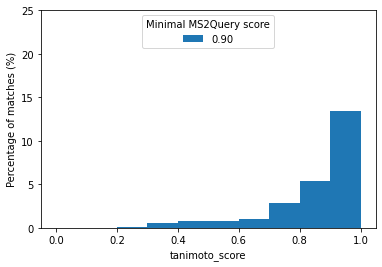

In [8]:
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_and_tanimoto, [0,0.5,0.6,0.7,0.8,0.9], "Minimal MS2Query score")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0,0.8,0.9,0.95, 0.97, 0.99], "Minimal MS2Deepscore")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_and_tanimoto, [0.753], "Minimal MS2Query score")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0.9415], "Minimal MS2Deepscore")
plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_and_tanimoto, [0.903], "Minimal MS2Query score")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0.9745], "Minimal MS2Deepscore")
# compare_tanimoto_score_distribution(ms2query_and_tanimoto, ms2ds_and_tanimoto, 0.753, 0.9415)
# compare_tanimoto_score_distribution(ms2query_and_tanimoto, ms2ds_and_tanimoto, 0.903, 0.9745)

# Plot optimal/random performance
To be able to compare the results to the best optimal performance, the tanimoto score distribution of the best possible matches for the test set used is plotted. Also the distribution for tanimoto scores is plotted, when matches would be selected completely at random. 

In [9]:
def plot_average_tanimoto_distribution(spectra, tanimoto_scores):
    bins = np.linspace(0, 1, 11)

    inchikeys = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    unique_inchikeys = list(set(inchikeys))
    
    all_inchikeys = []
    for row in unique_inchikeys:
        all_inchikeys += list(tanimoto_scores[row])
        
    weight_to_convert_to_percentage = 100/len(all_inchikeys)
    weights = [weight_to_convert_to_percentage] * len(all_inchikeys)
    plt.xlabel("tanimoto score")
    plt.ylabel("Percentage of matches (%)")
    plt.hist(all_inchikeys, weights = weights, bins = bins)
    plt.ylim(0,80)

    plt.show()


def plot_best_tanimoto_score_distribution(spectra, tanimoto_scores):
    inchikeys = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    unique_inchikeys = list(set(inchikeys))
    
    # remove unique inchikeys from rows
    tanimoto_scores_removed = tanimoto_scores[~tanimoto_scores.index.isin(unique_inchikeys)]
    highest_tanimoto_list = []
    for inchikey in inchikeys:
        highest_tanimoto_score = tanimoto_scores_removed[inchikey].max()
        highest_tanimoto_list.append(highest_tanimoto_score)
    
    weight_to_convert_to_percentage = 100/len(spectra)
    weights = [weight_to_convert_to_percentage] * len(highest_tanimoto_list)
    
    average_tanimoto = sum(highest_tanimoto_list)/len(inchikeys)
    print(average_tanimoto)
    plt.xlabel("tanimoto score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0,80)
    
    plt.hist(highest_tanimoto_list, weights = weights, bins = np.linspace(0, 1, 11))
    plt.show()

### Optimal results

0.9047104466324215


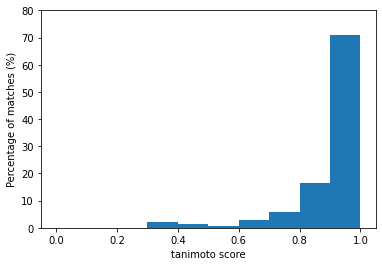

In [12]:
tanimoto_scores_df = load_pickled_file(tanimoto_scores_df_file)
plot_best_tanimoto_score_distribution(validation_spectra_without_match, tanimoto_scores_df)

### Random results

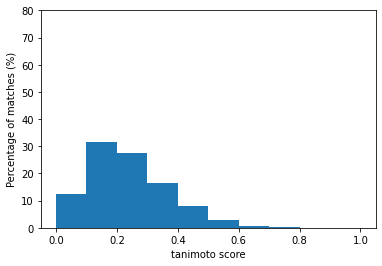

In [13]:
plot_average_tanimoto_distribution(validation_spectra_without_match, tanimoto_scores_df)

# Compare MS2Deepscore to MS2Query
To make it easier to compare the performance of MS2Deepscore and MS2Query the recall is plotted versus the average tanimoto score. 

In [14]:
def avg_tanimoto_vs_percentage_found(selection_criteria_and_tanimoto, cut_off_maximum, steps, legend_label):
    cut_offs = {}
    percentages_found = []
    average_tanimoto_score = []
    for i in range(steps):
        cut_off = cut_off_maximum/steps * i
        selected_scores = [scores[1] for scores in selection_criteria_and_tanimoto if scores[0] > cut_off]
        percentages_found.append(len(selected_scores)/len(selection_criteria_and_tanimoto)*100)
        average_tanimoto_score.append(sum(selected_scores)/len(selected_scores))
    plt.plot(percentages_found, average_tanimoto_score, label = legend_label)
    plt.xlim(100,0)
    plt.ylim(0, 1)
    plt.xlabel("Percentage matches found")
    plt.ylabel("Average tanimoto score")
    plt.legend(loc = "lower right", title = "Select on highest:")
    plt.show

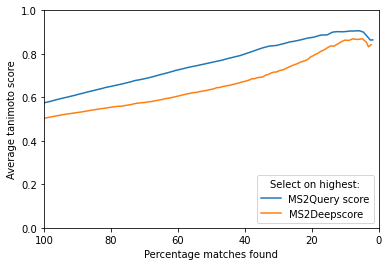

In [15]:
avg_tanimoto_vs_percentage_found(ms2query_and_tanimoto, 1.1, 100, "MS2Query score")
avg_tanimoto_vs_percentage_found(ms2ds_and_tanimoto, 1, 1000, "MS2Deepscore")

# Plot effect of preselection
As preselection MS2Deepscore is used. The number of spectra preselected with MS2Deepscore can be varried. The quality of matches found is plotted vs the number of spectra in the preselection. 

In [ ]:
def average_tanimoto_for_nr_preselected(scores, nr_of_spectra_preselection):
    for query_spectrum_id in scores:
        scores_df = scores[query_spectrum]
        print(scores_df)

# Format graphs with constant axises for report

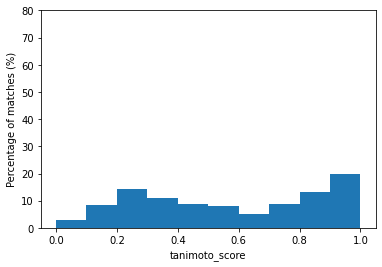

In [54]:
bins = np.linspace(0, 1, 11)

weight_to_convert_to_percentage = 100/len(ms2query_and_tanimoto)


selected_scores = [scores[1] for scores in ms2query_and_tanimoto]
weights = [weight_to_convert_to_percentage] * len(selected_scores)

plt.hist(selected_scores, bins, weights = weights)

plt.xlabel("tanimoto_score")
plt.ylabel("Percentage of matches (%)")
plt.ylim(0, 80)
plt.show()

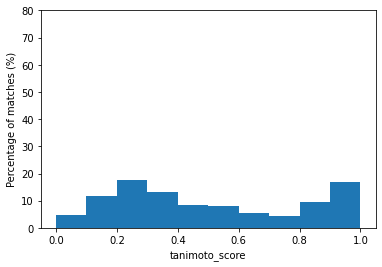

In [15]:
bins = np.linspace(0, 1, 11)

weight_to_convert_to_percentage = 100/len(ms2ds_and_tanimoto)


selected_scores = [scores[1] for scores in ms2ds_and_tanimoto]
weights = [weight_to_convert_to_percentage] * len(selected_scores)

plt.hist(selected_scores, bins, weights = weights)

plt.xlabel("tanimoto_score")
plt.ylabel("Percentage of matches (%)")
plt.ylim(0, 80)
plt.show()

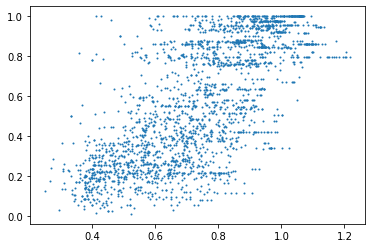

In [65]:
ms2query_list = []
tanimoto_list = []
for ms2query, tanimoto in ms2query_and_tanimoto:
    ms2query_list.append(ms2query)
    tanimoto_list.append(tanimoto)
plt.scatter(ms2query_list, tanimoto_list, s = 1)

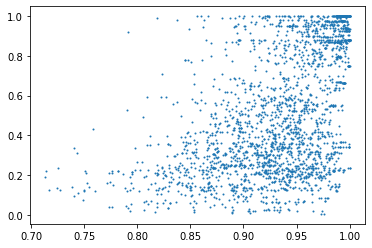

In [64]:
ms2query_list = []
tanimoto_list = []
for ms2query, tanimoto in ms2ds_and_tanimoto:
    ms2query_list.append(ms2query)
    tanimoto_list.append(tanimoto)
plt.scatter(ms2query_list, tanimoto_list, s = 1)

# Test speed performance

In [3]:
import time
ms2query_model = "../downloads/gnps_210409/train_ms2query_model/ms2query_model_all_scores.hdf5"
ms2library = MS2Library(sqlite_file, s2v_model_file, ms2ds_model_file, s2v_embeddings_file, ms2ds_embeddings_file)
start_time = time.time()
print("Calculating all MS2DS scores")
result = ms2library.analog_search(validation_spectra_without_match[:100], ms2query_model, preselection_cut_off = 2000)
print("Time elapsed = " + str(time.time()-start_time) + " seconds")
print(result)

Calculating all MS2DS scores


collecting matches info:   5%|██████▌                                                                                                                             | 5/100 [00:10<03:02,  1.92s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.01%.


collecting matches info:  13%|█████████████████                                                                                                                  | 13/100 [00:26<02:46,  1.92s/it]

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.


collecting matches info:  68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 68/100 [02:04<00:57,  1.78s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.


collecting matches info:  70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 70/100 [02:08<00:53,  1.78s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.


collecting matches info:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 77/100 [02:21<00:41,  1.79s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.


collecting matches info:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 78/100 [02:22<00:39,  1.79s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.


collecting matches info:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 93/100 [02:49<00:12,  1.78s/it]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.


collecting matches info: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.82s/it]


Time elapsed = 195.46253967285156 seconds
{'CCMSLIB00000085932':                     parent_mass*0.001  mass_similarity  s2v_score  \
CCMSLIB00000078399           0.404207     3.452758e-05   0.304973   
CCMSLIB00000084938           0.404210     3.455070e-05   0.298886   
CCMSLIB00003136516           0.404212     3.456612e-05   0.231789   
CCMSLIB00000079062           0.068028     9.100282e-38   0.202198   
CCMSLIB00000079133           0.068028     9.100282e-38   0.143959   
...                               ...              ...        ...   
CCMSLIB00005753937           0.266179     1.451680e-18   0.054576   
CCMSLIB00005753607           0.266179     1.451680e-18  -0.014892   
CCMSLIB00005754556           0.266179     1.451680e-18   0.003064   
CCMSLIB00005754897           0.266179     1.451680e-18   0.089838   
CCMSLIB00005754491           0.266179     1.451680e-18  -0.020003   

                    ms2ds_score  average_ms2ds_score_for_inchikey14  \
CCMSLIB00000078399     0.967794    